## Imports & Globals

In [97]:
from itertools import islice
import numpy as np

batch_size = 20
file_name = 'gps'
RANDOM_SEED = 42

## Load data

In [8]:
data = np.genfromtxt('./'+file_name+'.csv', delimiter=' ', dtype=np.float64)
print(data.dtype, data.shape, '\n', data[0])
data = data[data[:,4]==5] # grab only spiral 5
data = np.delete(data, [3,4,5], 1) # don't need ???, spiral id and certainty
data = data[data[:,0].argsort()] # assert chronological order
stamps = data[:,0]
median_time = np.median(np.diff(stamps)) // 1e6
data = np.delete(data, [0], 1) # don't need timestamps anymore
print('median_time:', median_time) # in milliseconds
print()
# display info to assert data is intact
print(data.shape)
print('mean: ' + ', '.join([f'{d:.4f}' for d in np.mean(data,axis=0)]))
print('std:  ' + ', '.join([f'{d:.4f}' for d in np.std(data,axis=0)]))
print()
print(*data[:5],sep='\n')

float64 (1996, 6) 
 [ 1.64200514e+18  5.96593803e+02  8.59940487e+02 -2.77736713e+00
  5.00000000e+00  5.24098638e-01]
median_time: 336.0

(1993, 2)
mean: 497.7611, 638.5479
std:  253.4107, 398.1898

[596.59380283 859.94048703]
[564.96110651 859.03152713]
[538.54520033 856.63155722]
[539.24309922 857.05656269]
[539.55922647 856.60149264]


## Transform & build dataloader

In [11]:
from itertools import islice
from collections import deque
        
def sliding_window(iterable, n):
    # sliding_window('ABCDEFG', 4) -> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)
    
print(next(sliding_window(data,5)))

(array([596.59380283, 859.94048703]), array([564.96110651, 859.03152713]), array([538.54520033, 856.63155722]), array([539.24309922, 857.05656269]), array([539.55922647, 856.60149264]))


In [130]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# build X&y sets
past_window = 30 # 10 seconds of past is about 30
future_window = 10
window_size = past_window + future_window
X = [window[:past_window] for window in sliding_window(data, window_size)]
Y = [window[past_window:] for window in sliding_window(data, window_size)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

# make sets pytorch friendly
transform = lambda x: torch.as_tensor(x, dtype=torch.float32).permute(0,2,1)
X_train, X_test = transform(X_train), transform(X_test)
Y_train, Y_test = transform(Y_train), transform(Y_test)
train_data = [*zip(X_train, Y_train)]
test_data  = [*zip(X_test, Y_test)]
train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data  = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Build model

In [199]:
from torchinfo import summary
import torch.nn as nn
import torch

class context_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(context_block, self).__init__()
        padding = (kernel_size - 1) // 2
        
        self.linear = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1),
            nn.InstanceNorm1d(out_channels),
            nn.ReLU(True),
        )

        self.conv = nn.Sequential(
            nn.ReflectionPad1d(padding=padding),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1),
            nn.InstanceNorm1d(out_channels),
            nn.ReLU(True),
            nn.ReflectionPad1d(padding=padding),
            nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1),
            nn.InstanceNorm1d(out_channels)
        )

    def forward(self, x):
        lin = self.linear(x)
        return lin + self.conv(lin)
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, norm=True, activation=True):
        super(ConvBlock, self).__init__()
        padding = (kernel_size - stride) // 2 if not padding else padding
        self.layers  = []
        self.layers += [nn.ReflectionPad1d(padding=padding)]
        self.layers += [nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)]
        self.layers += [nn.InstanceNorm1d(out_channels)] if norm else []
        self.layers += [nn.ReLU(True)] if activation else []
        self.layers  = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)
    
class encodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(encodingBlock, self).__init__()
        self.layers  = []
        self.layers += [ConvBlock(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=2)]
        self.layers += [ConvBlock(out_channels, out_channels, kernel_size=kernel_size, stride=1)]
        self.layers  = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)
    
class decodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(decodingBlock, self).__init__()
        padding = (kernel_size - stride) // 2
        self.layers  = []
        self.layers += [ConvBlock(in_channels, out_channels, kernel_size=kernel_size, stride=1)]
        self.layers += [nn.ConvTranspose1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size-1, padding=padding, stride=stride)]
        self.layers += [nn.InstanceNorm1d(out_channels)]
        self.layers += [nn.ReLU(True)]
        self.layers  = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)
    
class LSTM_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LSTM_Block, self).__init__()
        self.lstm = nn.LSTM(input_size=in_channels, hidden_size=out_channels, batch_first=True)
        
        self.layers  = []
        self.layers += [nn.InstanceNorm1d(out_channels)]
        self.layers += [nn.ReLU(True)]
        self.layers  = nn.Sequential(*self.layers)

    def forward(self, x):
        out = x.permute(0,2,1)
        out, _ = self.lstm(out)
        out = out.permute(0,2,1)
        out = self.layers(out)
        return out
    
class generator(nn.Module):
    def __init__(self, in_channels, l=32):
        super(generator, self).__init__()
        self.layers  = []
        self.layers += [context_block(in_channels, l, kernel_size=5)]
        self.layers += [encodingBlock(l, l*2, kernel_size=5, stride=2)]
        self.layers += [LSTM_Block(l*2, l*2)]
        self.layers += [decodingBlock(l*2, l, kernel_size=5, stride=2)]
        self.layers += [ConvBlock(l, in_channels, kernel_size=1, stride=1, activation=False, norm=False)]
        self.layers  = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)
    
summary(generator(2), input_size=(batch_size, 2,past_window)) # Note: torchsummary does not support rnn. use torchinfo

Layer (type:depth-idx)                                  Output Shape              Param #
generator                                               --                        --
├─Sequential: 1-1                                       [20, 2, 30]               --
│    └─context_block: 2-1                               [20, 16, 30]              --
│    │    └─Sequential: 3-1                             [20, 16, 30]              48
│    │    └─Sequential: 3-2                             [20, 16, 30]              2,592
│    └─encodingBlock: 2-2                               [20, 32, 15]              --
│    │    └─Sequential: 3-3                             [20, 32, 15]              7,744
│    └─LSTM_Block: 2-3                                  [20, 32, 15]              --
│    │    └─LSTM: 3-4                                   [20, 15, 32]              8,448
│    │    └─Sequential: 3-5                             [20, 32, 15]              --
│    └─decodingBlock: 2-4                          

In [188]:
# from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train(model, dataloader, optimizer, loss_fn):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred[:,:,-future_window:], y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"\rloss: {loss:>7f}  [{current:>5d}/{size:>5d}]",end=' '*10)

def evaluate(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[:,:,-future_window:], y).item()

    test_loss /= num_batches
    print(f'Test avg loss: {test_loss:>8f}')


In [180]:
def save(model, epoch):
    path = f'./model_{epoch}.pth'
    torch.save({
        'model': model.state_dict(),
        'start_epoch': epoch,
    }, path)

def load(model, epoch):
    path = f'./model_{epoch}.pth'
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model'])
    return model

## Run model

In [201]:
learning_rate = 0.003
num_epoch = 10
load_epoch = 100 # set to None to make new model

model = generator(2, l=64)
model = model if not load_epoch else load(model, load_epoch)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

start = 0 if not load_epoch else load_epoch
for epoch in range(start, start+num_epoch):
    print(f'\nepoch: {epoch}')
    train(model, train_data, optimizer, loss_fn)
    evaluate(model, test_data, loss_fn)
    
save(model, start+num_epoch)


epoch: 100
loss: 215.279434  [ 1400/ 1465]          Test avg loss: 14336.026113

epoch: 101
loss: 190.293854  [ 1400/ 1465]          Test avg loss: 13558.757441

epoch: 102
loss: 106.977692  [ 1400/ 1465]          Test avg loss: 12563.371221

epoch: 103
loss: 172.571915  [ 1400/ 1465]          Test avg loss: 14186.733555

epoch: 104
loss: 78.534203  [ 1400/ 1465]           Test avg loss: 12740.971699

epoch: 105
loss: 208.392426  [ 1400/ 1465]          Test avg loss: 13165.838691

epoch: 106
loss: 119.577034  [ 1400/ 1465]          Test avg loss: 14100.117695

epoch: 107
loss: 152.300140  [ 1400/ 1465]          Test avg loss: 12806.124795

epoch: 108
loss: 199.848892  [ 1400/ 1465]          Test avg loss: 13377.092979

epoch: 109
loss: 75.841316  [ 1400/ 1465]           Test avg loss: 14199.876504


In [202]:
# grab one prediction for sanity check
model(next(iter(test_data))[0])[0]

tensor([[  18.1100,   18.1100,   18.1100,   18.1100,   19.4775,   18.4464,
          194.4022,   84.2433,  320.6735,  274.7654,  420.2895,  376.2742,
          332.0594,  237.7565,   29.0488,   -4.5952,   58.3750,   84.0662,
          331.3107,  335.8178,  372.4052,  392.6818,  421.7058,  460.2317,
          477.4225,  500.3753,  519.6375,  544.9751,  575.7656,  596.7710],
        [   9.8517,    9.8517,    9.8517,    9.8517,   14.5171,   10.8436,
          564.5469,  682.3610, 1254.1078, 1192.0011, 1454.3859, 1428.7787,
         1188.0881, 1085.8263,  384.7263,  322.0287,   84.9029,   98.5817,
           93.6541,   85.1470,  100.9946,   74.5253,   58.6965,   49.6828,
           49.1146,   45.1303,   39.1531,   44.4143,   60.3406,   60.2862]],
       grad_fn=<SelectBackward>)

In [203]:
# ... and compare (last 10 from prediction) with corresponding truth
next(iter(test_data))[1][0]

tensor([[186.9667, 209.9833, 238.9315, 267.0697, 291.5562, 316.9608, 316.9608,
         360.8017, 386.0000, 416.9677],
        [151.9661, 138.0167, 133.2645, 124.9635, 110.6341,  97.0011,  97.0011,
          79.5772,  74.9613,  68.0000]])

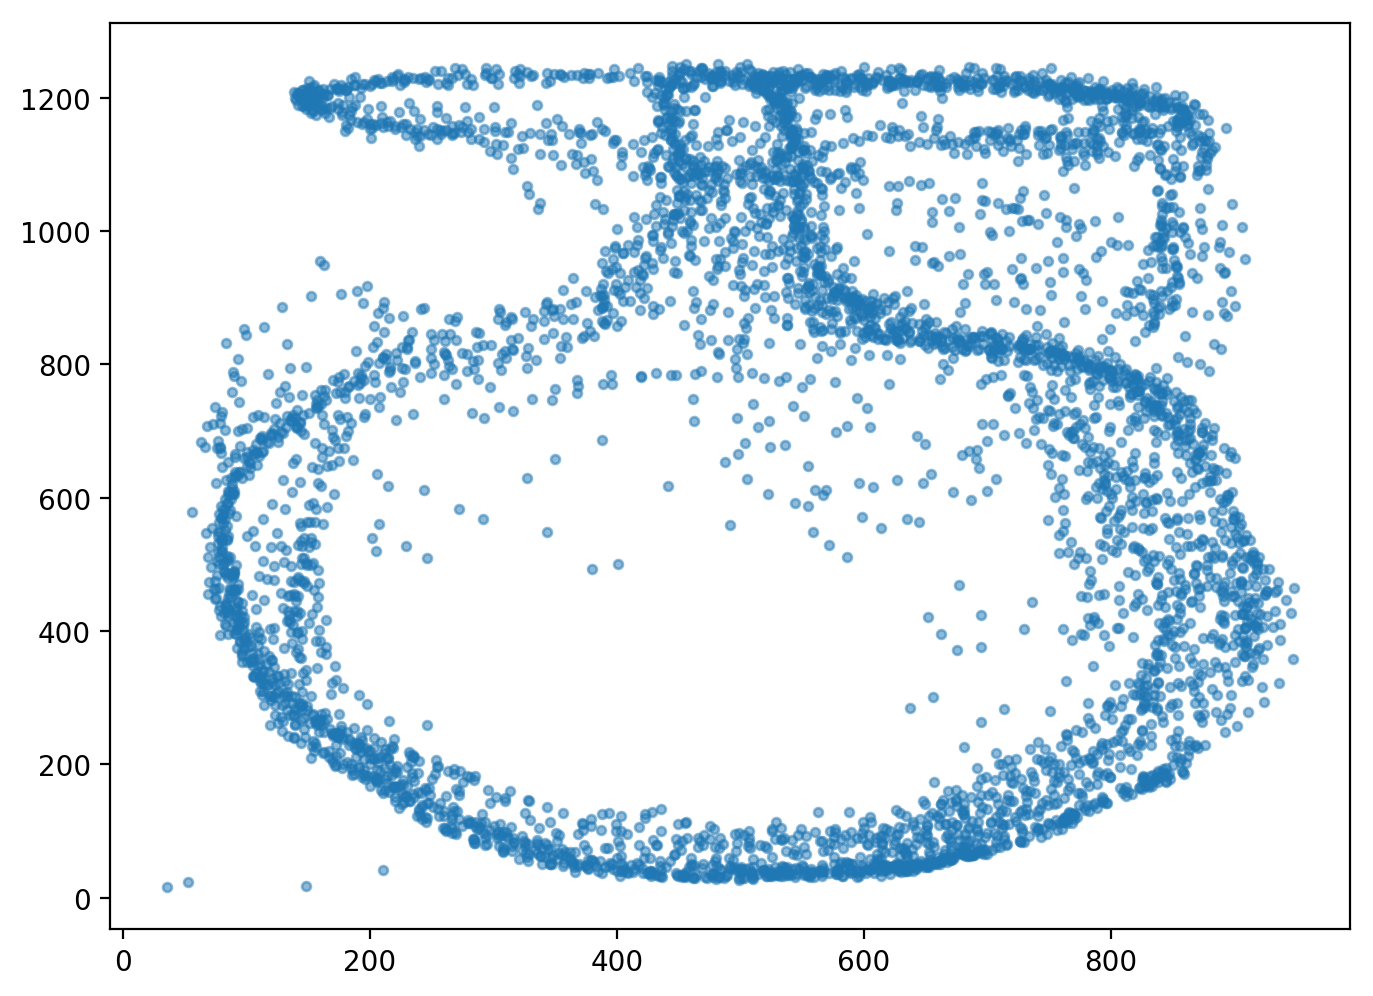

In [249]:
# make a pretty plot to see what is going on
import matplotlib.pyplot as plt
%matplotlib inline
preds = []
truth = []
with torch.no_grad():
    for X, y in test_data:
        pred = model(X)
        pred = pred[:,:,-future_window:]
        pred = pred.permute(0, 2, 1)
        pred = torch.flatten(pred, end_dim=1)
        preds += pred
        
        trut = y.permute(0, 2, 1)
        trut = torch.flatten(trut, end_dim=1)
        truth += trut

x,y = [*zip(*preds)]
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(x=x,y=y, s=10, alpha=0.5);
plt.savefig('predictions.png');

### TODO
- try AAL transform from https://github.com/nbro/aal/blob/master/aal.py